# Plotting

``tabensemb.trainer.Trainer`` provides some useful plotting methods to analyse the dataset or results.

In [1]:
import torch
from tabensemb.trainer import Trainer
from tabensemb.model import *
from tabensemb.config import UserConfig
import tabensemb
import os
from tempfile import TemporaryDirectory

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

temp_path = TemporaryDirectory()
tabensemb.setting["default_output_path"] = os.path.join(temp_path.name, "output")
tabensemb.setting["default_config_path"] = os.path.join(temp_path.name, "configs")
tabensemb.setting["default_data_path"] = os.path.join(temp_path.name, "data")

trainer = Trainer(device=device)
mpg_columns = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model_year",
    "origin",
    "car_name",
]
cfg = UserConfig.from_uci("Auto MPG", column_names=mpg_columns, sep=r"\s+")
trainer.load_config(cfg)
trainer.load_data()
models = [
    PytorchTabular(trainer, model_subset=["Category Embedding"]),
    CatEmbed(trainer, model_subset=["Category Embedding"])
]
trainer.add_modelbases(models)
trainer.train(stderr_to_stdout=True)

Using cuda device
cylinders is Integer and will be treated as a continuous feature.
model_year is Integer and will be treated as a continuous feature.
origin is Integer and will be treated as a continuous feature.
Unknown values are detected in ['horsepower']. They will be treated as np.nan.
The project will be saved to /tmp/tmpcqd3wxwr/output/auto-mpg/2023-09-05-20-23-34-0_UserInputConfig
Dataset size: 238 80 80
Data saved to /tmp/tmpcqd3wxwr/output/auto-mpg/2023-09-05-20-23-34-0_UserInputConfig (data.csv and tabular_data.csv).

-------------Run PytorchTabular-------------

Training Category Embedding
Global seed set to 42
2023-09-05 20:23:35,299 - {pytorch_tabular.tabular_model:473} - INFO - Preparing the DataLoaders
2023-09-05 20:23:35,300 - {pytorch_tabular.tabular_datamodule:290} - INFO - Setting up the datamodule for regression task
2023-09-05 20:23:35,308 - {pytorch_tabular.tabular_model:521} - INFO - Preparing the Model: CategoryEmbeddingModel
2023-09-05 20:23:35,319 - {pytorch

If LaTeX is detected, `matplotlib.rc("text", usetex=True)` is called to use LaTeX for a better text appearance. However, if there exist `"_"` in feature names, LaTeX will throw errors. Here we reset defaults of `matplotlib.rcParams` to disable LaTeX.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams["figure.autolayout"] = True

`Trainer.plot_feature_box` will show the box plot of features.

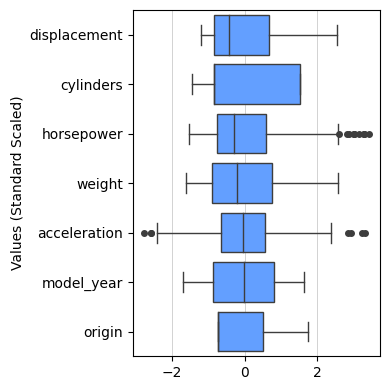

In [3]:
trainer.plot_feature_box(imputed=True, figure_kwargs=dict(figsize=(4, 4)))

`Trainer.plot_pairplot` will show correlations between each two features. It uses `seaborn.pairplot` to achieve this, so the plot can be customized by passing the `pairplot_kwargs` argument. See [the documentation](https://seaborn.pydata.org/generated/seaborn.pairplot.html) for possible arguments.


**Remark**: All methods introduced in this part pass arguments, such as `figure_kwargs`, `bar_kwargs`, `pairplot_kwargs`, etc., to corresponding functions for limited but sufficient customization. See the API docs for their meanings.

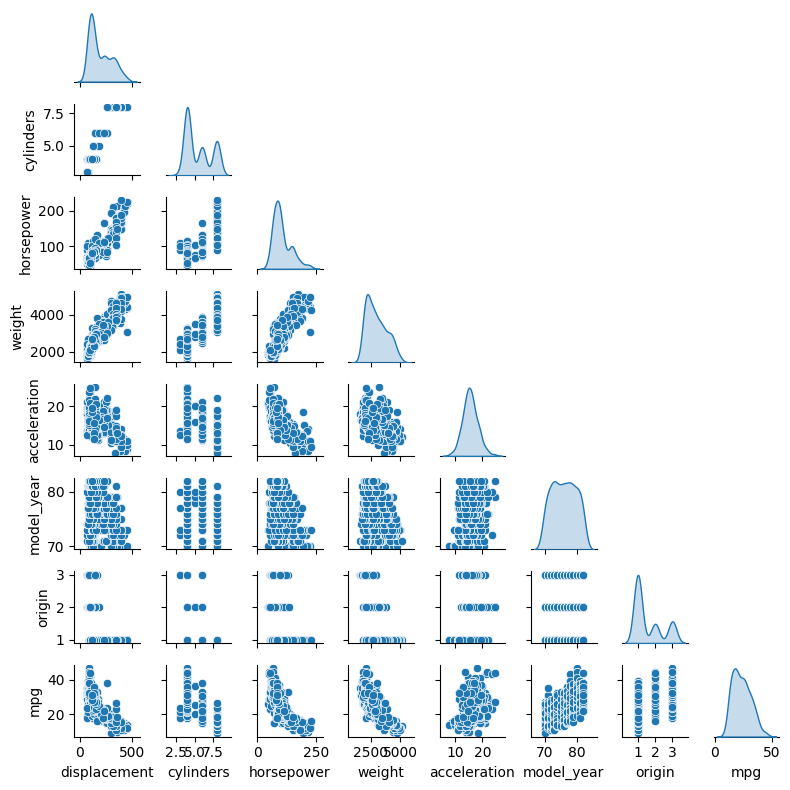

In [4]:
trainer.plot_pairplot(pairplot_kwargs=dict(height=1))

`Trainer.plot_corr` will show the Pearson correlation coefficients between each two features.

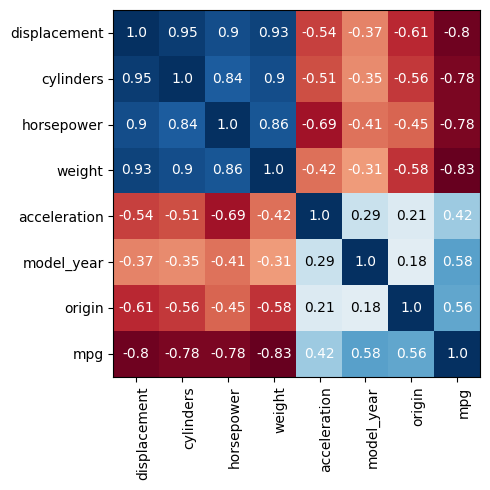

In [5]:
trainer.plot_corr(imputed=True, figure_kwargs=dict(figsize=(5, 5)), imshow_kwargs=dict(cmap="RdBu"))

`Trainer.plot_truth_pred` will show the comparison between ground truth values and predictions.

Category Embedding 1/1
Category Embedding 1/1
Training MSE Loss: 11.2517, R2: 0.8254
Validation MSE Loss: 12.3673, R2: 0.7791
Testing MSE Loss: 7.8380, R2: 0.8542


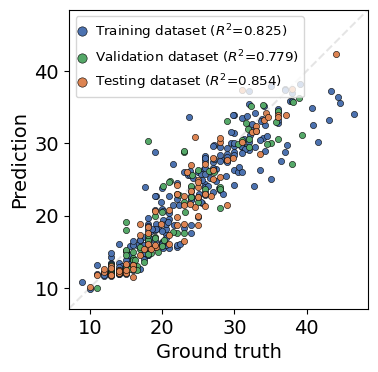

In [6]:
trainer.plot_truth_pred(program="PytorchTabular", log_trans=False, legend_kwargs=dict(fontsize="x-small"), figure_kwargs=dict(figsize=(4, 4)))

`Trainer.plot_feature_importance` calculates and plots feature importance. Two methods are supported to calculate feature importance: `permutation` and `shap`. [Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature.) is the decrease of the metric when permuting (shuffling) the feature. [SHAP](https://github.com/shap/shap) is a game theory approach. They might get different results.

For `pytorch` based models, we use `captum` ([link](https://captum.ai/docs/introduction)) and `shap.DeepExplainer` ([link](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html)) for faster calculations.

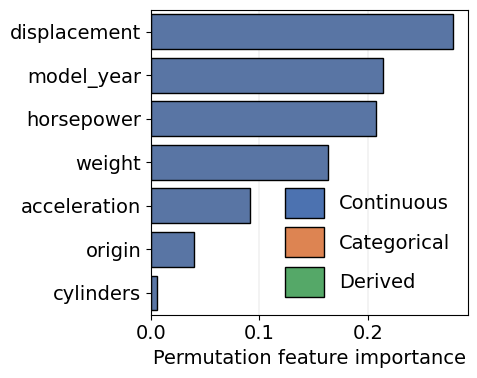

In [7]:
trainer.plot_feature_importance(program="PytorchTabular", model_name="Category Embedding", figure_kwargs=dict(figsize=(5, 4)))

Feature importance less than 1e-5: ['Unscaled (dim 0)', 'Unscaled (dim 1)', 'Unscaled (dim 2)', 'Unscaled (dim 3)', 'Unscaled (dim 4)', 'Unscaled (dim 5)', 'Unscaled (dim 6)']


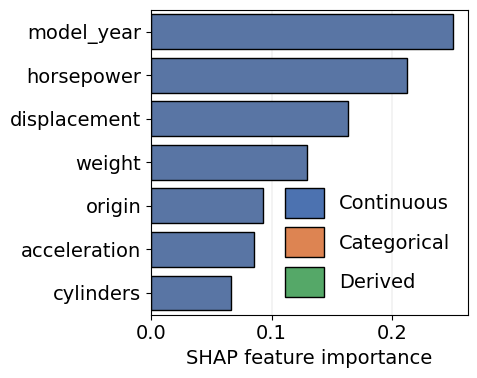

In [8]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    trainer.plot_feature_importance(program="CatEmbed", model_name="Category Embedding", method="shap", figure_kwargs=dict(figsize=(5, 4)))

`Trainer.plot_partial_dependence` uses bootstrap sampling to resample the dataset, fits the model on the resampled dataset, and obtains sequential predictions when assigning sequential values to a feature, to see the dependency of predictions on a feature.

Calculate PDP:  displacement
Calculate PDP:  cylinders
Calculate PDP:  horsepower
Calculate PDP:  weight
Calculate PDP:  acceleration
Calculate PDP:  model_year
Calculate PDP:  origin


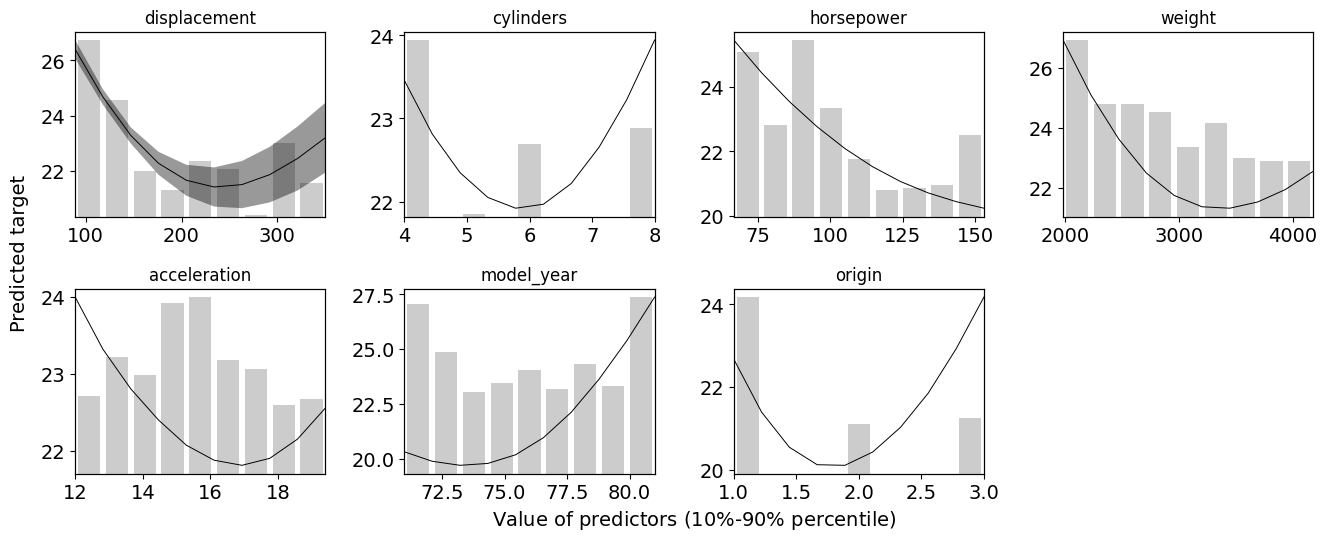

In [9]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    trainer.plot_partial_dependence(program="PytorchTabular", model_name="Category Embedding", n_bootstrap=3, grid_size=10, log_trans=False, upper_lim=9, lower_lim=2, CI=0.95)

`Trainer.plot_partial_err` shows the distribution of absolute error with respect to feature values. If the density of high error predictions is high in a certain range of a certain feature, data augmentation or additional experiments might be required.

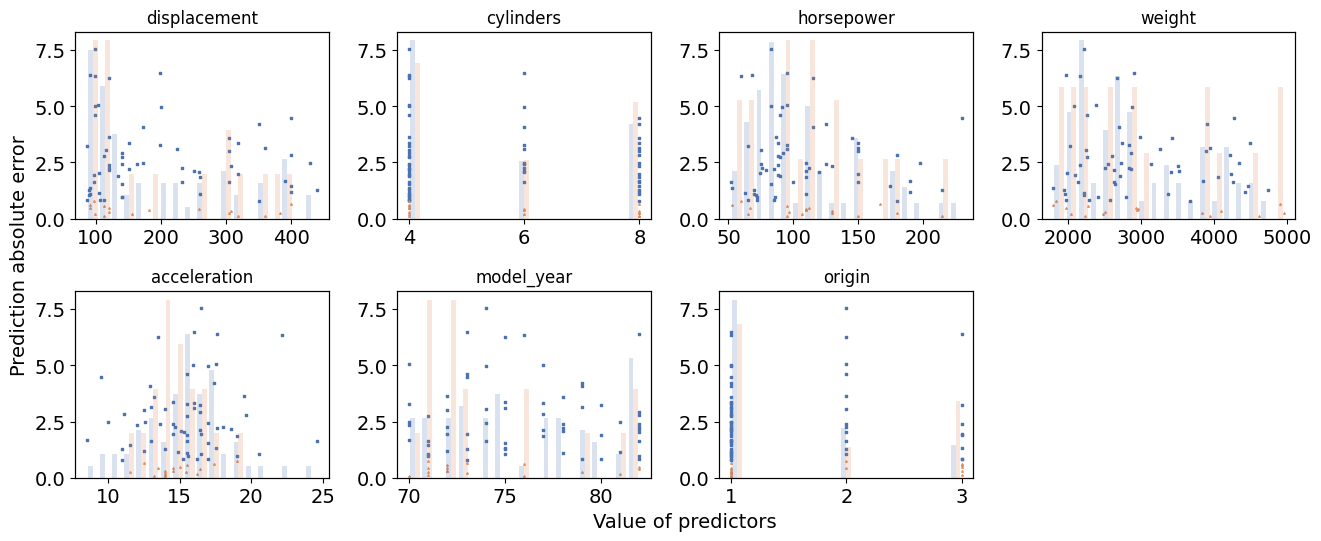

In [10]:
trainer.plot_partial_err(program="PytorchTabular", model_name="Category Embedding")